# HAR LSTM training 

In [1]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

# def standardize(train, test):
# 	""" Standardize data """

# 	# Standardize train and test
# 	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
# 	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

# 	return X_train, X_test

# def one_hot(labels, n_class = 6):
# 	""" One-hot encoding """
# 	expansion = np.eye(n_class)
# 	y = expansion[:, labels-1].T
# 	assert y.shape[1] == n_class, "Wrong number of labels!"

# 	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

## Prepare data

In [2]:
Xtrain, Ytrain, list_ch_train = read_data(data_path="/home/arasdar/datasets/har-data/", split="train") # train
Xtest, Ytest, list_ch_test = read_data(data_path="/home/arasdar/datasets/har-data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:
# # Standardize
# X_train, X_test = standardize(X_train, X_test)
# print(X_train.shape, X_test.shape)

Train/Validation Split

In [5]:
from sklearn.model_selection import train_test_split

Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, stratify = Ytrain, random_state = 123)

In [6]:
print(Xtrain.shape, Xtrain.dtype)
print(Xvalid.shape, Xvalid.dtype)
print(Xtest.shape, Xtest.dtype)
print(Ytrain.shape, Ytrain.dtype)
print(Yvalid.shape, Yvalid.dtype)
print(Ytest.shape, Ytest.dtype)

(5514, 128, 9) float64
(1838, 128, 9) float64
(2947, 128, 9) float64
(5514,) int64
(1838,) int64
(2947,) int64


One-hot encoding:

In [7]:
# y_tr = one_hot(lab_tr)
# y_vld = one_hot(lab_vld)
# y_test = one_hot(labels_test)

### Hyperparameters

In [18]:
# Imports
import tensorflow as tf

lstm_size = 27         # 3 times the amount of channels
lstm_layers = 1        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [9]:
# graph = tf.Graph()

# Construct placeholders
# with graph.as_default():
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
indices_ = tf.placeholder(tf.int32, [None], name = 'indices')
#     keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
#     learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [10]:
# with graph.as_default():
# Construct the LSTM inputs and LSTM cells
print(inputs_.shape)
lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape)
lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
print(lstm_in.shape)

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(lstm_in, seq_len, 0)
print(len(lstm_in), lstm_in[0].shape)

# Add LSTM layers
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
#     drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
cell = tf.contrib.rnn.MultiRNNCell([lstm] * lstm_layers)
initial_state = cell.zero_state(batch_size, tf.float32)

(?, 128, 9)
(128, ?, 9)
(?, 9)
128 (?, 9)


Define forward pass, cost function and optimizer:

In [11]:
# with graph.as_default():
# with tf.variable_scope('RNN', reuse=True):
outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state = initial_state)

# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
labels = tf.one_hot(depth=n_classes, indices=indices_)

# Loss/cost using labels and logits
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))

# Accuracy using logits and labels
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Optimize using loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) # No grad clipping

In [12]:
print(len(outputs), outputs[0].shape)

128 (600, 27)


In [14]:
print(cost)

Tensor("Mean:0", shape=(), dtype=float32)


In [15]:
print(logits)

Tensor("logits/BiasAdd:0", shape=(600, 6), dtype=float32)


### Train the network

In [16]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [17]:
valid_acc, valid_loss = [], []
train_acc, train_loss = [], []

# with graph.as_default():
saver = tf.train.Saver()

with tf.Session() as sess:
    # Initialize the global variable instead of loading them or if there is nothing to load.
    sess.run(tf.global_variables_initializer())
    
    #     # Restore
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #     saver.restore(sess,"checkpoints/har-lstm.ckpt")
    
    for e in range(epochs):
        
        # Loop over training batches
        state = sess.run(initial_state)
        train_acc_batch, train_loss_batch = [], []
        for Xbatch, Ybatch in get_batches(Xtrain, Ytrain, batch_size):
            
            # Feed dictionary
            feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
            loss, state, acc, _ = sess.run([cost, final_state, accuracy, optimizer], feed_dict)
            train_acc_batch.append(acc)
            train_loss_batch.append(loss)
            
        # Print at each epoch/iteration
        print("Epoch: {}/{}".format(e, epochs),
              "Train loss: {}".format(np.mean(train_loss_batch)),
              "Train acc: {}".format(np.mean(train_acc_batch)))

        # Store at each epoch/iteration
        train_loss.append(np.mean(train_loss_batch))
        train_acc.append(np.mean(train_acc_batch))
        
        # Loop over validation batches
        state = sess.run(initial_state)
        valid_acc_batch, valid_loss_batch = [], []
        for Xbatch, Ybatch in get_batches(Xvalid, Yvalid, batch_size):
            
            # Feed dictionary
            feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
            loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict)
            valid_acc_batch.append(acc)
            valid_loss_batch.append(loss)
            
        # Print at each epoch/iteration
        print("Epoch: {}/{}".format(e, epochs),
              "Valid loss: {}".format(np.mean(valid_loss_batch)),
              "Valid acc: {}".format(np.mean(valid_acc_batch)))

        # Store at each epoch/iteration
        valid_loss.append(np.mean(valid_loss_batch))
        valid_acc.append(np.mean(valid_acc_batch))
            
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/100 Train loss: 1.4368871450424194 Train acc: 0.23981481790542603
Epoch: 0/100 Valid loss: 1.394628882408142 Valid acc: 0.25999999046325684
Epoch: 1/100 Train loss: 1.373529076576233 Train acc: 0.2705555856227875
Epoch: 1/100 Valid loss: 1.3365325927734375 Valid acc: 0.26944443583488464
Epoch: 2/100 Train loss: 1.3130236864089966 Train acc: 0.2746296525001526
Epoch: 2/100 Valid loss: 1.2700577974319458 Valid acc: 0.3011111319065094
Epoch: 3/100 Train loss: 1.2362240552902222 Train acc: 0.33407407999038696
Epoch: 3/100 Valid loss: 1.184567928314209 Valid acc: 0.3405555486679077
Epoch: 4/100 Train loss: 1.1715781688690186 Train acc: 0.33703702688217163
Epoch: 4/100 Valid loss: 1.1382298469543457 Valid acc: 0.3611111342906952
Epoch: 5/100 Train loss: 1.1389400959014893 Train acc: 0.371111124753952
Epoch: 5/100 Valid loss: 1.1110707521438599 Valid acc: 0.3638888895511627
Epoch: 6/100 Train loss: 1.0949287414550781 Train acc: 0.4033333361148834
Epoch: 6/100 Valid loss: 1.0552085638

Epoch: 55/100 Train loss: 0.34996452927589417 Train acc: 0.7177777886390686
Epoch: 55/100 Valid loss: 0.367866188287735 Valid acc: 0.7005555629730225
Epoch: 56/100 Train loss: 0.35644906759262085 Train acc: 0.7131481766700745
Epoch: 56/100 Valid loss: 0.3553448021411896 Valid acc: 0.7233333587646484
Epoch: 57/100 Train loss: 0.33091235160827637 Train acc: 0.7257407307624817
Epoch: 57/100 Valid loss: 0.33419355750083923 Valid acc: 0.7255555987358093
Epoch: 58/100 Train loss: 0.31831789016723633 Train acc: 0.7294444441795349
Epoch: 58/100 Valid loss: 0.32986530661582947 Valid acc: 0.7200000286102295
Epoch: 59/100 Train loss: 0.3157537281513214 Train acc: 0.727222204208374
Epoch: 59/100 Valid loss: 0.3185126781463623 Valid acc: 0.7266666889190674
Epoch: 60/100 Train loss: 0.3127605617046356 Train acc: 0.727222204208374
Epoch: 60/100 Valid loss: 0.33131036162376404 Valid acc: 0.7238888740539551
Epoch: 61/100 Train loss: 0.31388527154922485 Train acc: 0.7283333539962769
Epoch: 61/100 Valid 

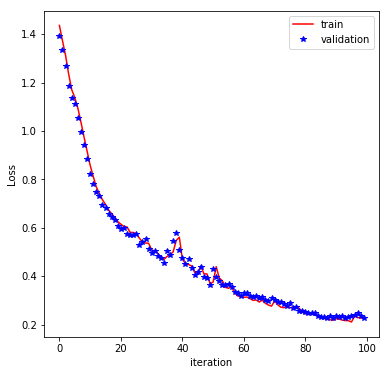

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training and test loss
plt.figure(figsize = (6,6))
plt.plot(np.array(train_loss), 'r-', np.array(valid_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

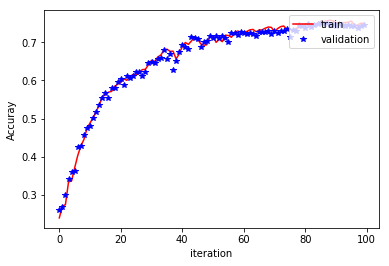

In [22]:
# Plot Accuracies
plt.plot(np.array(train_acc), 'r-', valid_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [25]:
loss, acc = [], []

with tf.Session() as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    # Loop over test batches
    state = sess.run(initial_state)
    acc_batch, loss_batch = [], []
    for Xbatch, Ybatch in get_batches(Xtest, Ytest, batch_size):

        # Feed dictionary
        feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
        loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print at each epoch/iteration
    print("Epoch: {}/{}".format(e, epochs),
          "Test loss: {}".format(np.mean(loss_batch)),
          "Test acc: {}".format(np.mean(acc_batch)))

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Epoch: 99/1000 Test loss: 0.4521060883998871 Test acc: 0.6808333396911621
